# **Practical session n°7** : Learning-to-Rank and Re-identification

**Part I:**

Several problems fall under the label "[learning-to-rank](https://link.springer.com/content/pdf/10.1007/978-3-642-15880-3_20.pdf)." One example is sorting a given list of labels (e.g. URL of websites) by relevance to an input query. This problem is referred to as *label ranking*.\
 In another scenario, input objects (e.g. images) should be sorted wrt a given criterion (e.g. 'foggy' or 'snowy'). Terms like *object ranking* and *learning to order things* are often used to describe this situation. In both cases, the learning is based on sorted samples, such as pairs of ordered images.

In this practical session, we illustrate the latter scenario using very simple synthetic images. All images consist of a mixture of a disc and a variable number of rectangles of different shapes. The goal is to sort the images based on the pixel intensity on the disc. To achieve this, we work in a standard context where we have pairs of ordered images. Using these pairs, we will train a neural network to construct a real-valued "ranking function" (*ranker*) whose outputs enable the sorting of images.

**Exercise #1:** Problem Construction

The following cells enable you to:
- generate a dataset on your drive (train+val and test),
- define a dataset that provides pairs of images and a comparison based on the criterion of disc intensity ("0" if the disc is more intense in the first image, "1" otherwise),
- visualize an initial batch.

In [22]:
import os
from os.path import join
ls = lambda rep: sorted(os.listdir(rep))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader, sampler

import matplotlib.pyplot as plt
import copy
from random import randint, choice



In [23]:
# imports from a git repo
#! git clone https://github.com/relmonta/ml-student.git
os.chdir('ml-student/TP7')

# from archis import *
from utile_tp7_partI import *
#from train_and_test import *

root = r"/content"

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
dir_trainval = join(root, r"train")
generate_dataset(dir_trainval, size_dataset=10000)

dir_test = join(root, r"test")
generate_dataset(dir_test, size_dataset=2000)

In [26]:
# Retrieving target values

# Image paths:
dir_images_trainval = os.path.join(dir_trainval, 'images')
dir_images_test = os.path.join(dir_test, 'images')

# Target values for train+val
label_dict_path_trainval = os.path.join(dir_trainval, 'labels_synthese.pickle')
with open(label_dict_path_trainval, 'rb') as handle:
    label_dict_trainval = pickle.load(handle)

# Target values for test
label_dict_path_test = os.path.join(dir_test, 'labels_synthese.pickle')
with open(label_dict_path_test, 'rb') as handle:
    label_dict_test = pickle.load(handle)

# Splitting train / val (8000/2000)
all_image_names = np.array(ls(dir_images_trainval))

train_indices = list(range(0, 8000))
names_train = all_image_names[train_indices]
val_indices = list(range(8000, 10000))
names_val = all_image_names[val_indices]
names_test = ls(dir_images_test)

# Note: for random splitting, use sklearn.model_selection.train_test_split as tts

In [27]:
# Just in case:
# from shutil import rmtree
# rmtree(dir_test)

In [28]:
# Data Augmentation
class SuperFlip(object):
    """
    The 8 transformations
    generated by R(Pi/2) and vertical symmetry/axis
    """
    def __init__(self, num_transforms):
        self.num_transforms = num_transforms

    def __call__(self, image):
        # Note: Ideally, torch.randint should be used here...
        n = randint(0, self.num_transforms)
        if n == 1:
            image = image.flip([1])
        elif n == 2:
            image = image.flip([2])
        elif n == 3:
            image = image.transpose(1, 2)
        elif n == 4:
            image = image.transpose(1, 2).flip([1])
        elif n == 5:
            image = image.transpose(1, 2).flip([2])
        elif n == 6:
            image = image.flip([1, 2])
        elif n == 7:
            image = image.transpose(1, 2).flip([1, 2])
        return image

super_flip_transform = SuperFlip(8)

transforms = {
    'train': super_flip_transform,
    'val': None,
    'test': None
}

In [29]:
# Dataset Construction:
def oracle(name0, name1, data_dict):
    # Load the data:
    y0 = data_dict[name0]['y']
    y1 = data_dict[name1]['y']

    # Determine the comparison:
    compa = 0 if y1 < y0 else 1
    return compa

class DatasetOrderedPairs(torch.utils.data.Dataset):
    def __init__(self, images_dir, data_dict, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.imgs = ls(images_dir)
        self.data_dict = data_dict

    def __getitem__(self, idx):
        name0 = self.imgs[idx]
        name1 = choice(self.imgs)
        label = oracle(name0, name1, self.data_dict)

        # Get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 = torch.load(path0)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array(label)).long(), name0, name1   # -1 if no class 0

    def __len__(self):
        return len(self.imgs)

In [30]:
# Dataset instantiation:
dataset_train = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['train'])
dataset_val = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['val'])
dataset_test = DatasetOrderedPairs(dir_images_test, label_dict_test, transforms['test'])

datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

In [31]:
# Samplers and loaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

samplers = {'train': train_sampler, 'val': val_sampler}

batch_size = 64

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=False, sampler=samplers[x], num_workers=2) for x in ['train', 'val']}
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
dataset_sizes = {'train': len(names_train), 'val': len(names_val), 'test': len(names_test)}

dataloaders['viz'] = torch.utils.data.DataLoader(datasets['train'], batch_size=6, shuffle=False, num_workers=0)

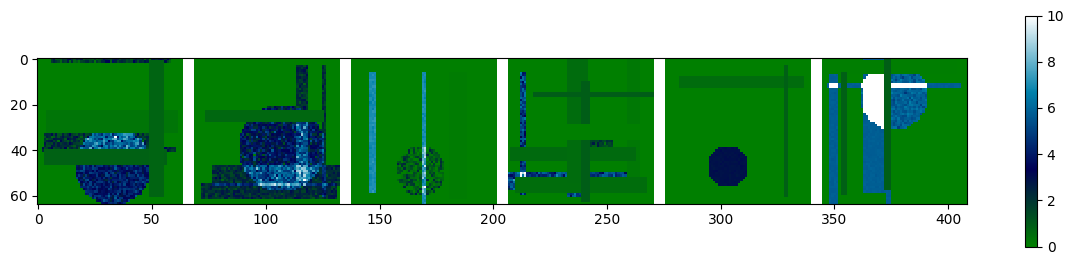

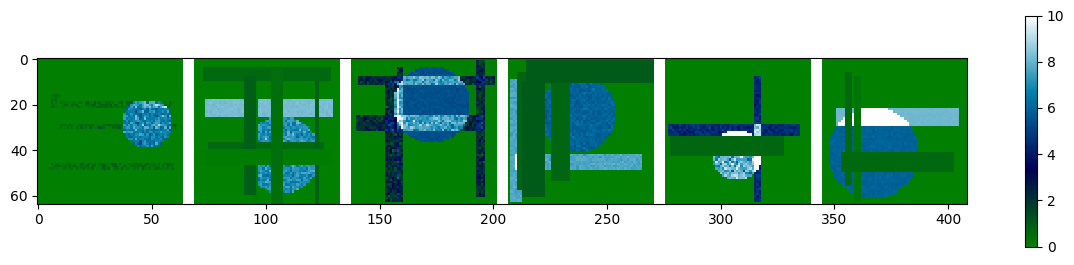

tensor([1, 1, 1, 1, 1, 1])


In [32]:
# Visualisation

img1, img2, labels, _, _ = next(iter(dataloaders['viz']))

fig0 = plt.figure(0, figsize=(15, 3))
voir_batch2D(img1, nx = 8, fig = fig0, k=0, min_scale=0,max_scale=10)
fig1 = plt.figure(1, figsize=(15, 3))
voir_batch2D(img2, nx = 8, fig = fig1, k=0, min_scale=0,max_scale=10)

print(labels)


**Q0** How is done the separation between training and validation done here?

On va donner les indices associés au train et au jeu de validatoins, les 8000 premières associées à l'entrainênement et les 2000 dernièers à l avalidatoin. Normalement, on prend toujours un sous échantillon aléatoire, puis ensuite on fait un sampler (qui va choisir les images de manière aléatoire)

**Q1** What is the role of *super_flip*? And that of the *oracle* function?

The rôle of super_flip is the data augmentation, indeed, the intensity is not modified and then we will have a better accuracy / precision.

Pour le training, on fait des modificatoins de transposition et de flip (rotation de $\frac{\pi}{2}$) sur les images tandis que pour la validation, nous n'effectuons aucune modifications sur les images d'origine.

Fonction oracle, comme on constriut les images, cela permet from intensité d'obtenir la vérité terrain : 0 ou 1. (si supérieur ou inférieur (comparaison des deux images))

**Q2** Are all pairs of images equally easy to order?

Comme on cherche à ordonner les intensités des disques, si les intensités sont proches, cela devrait être compliqué à les comparer (et aussi pour d'autres raisons..)

**Exercise #2:** Siamese Learning

During training, batches of image pairs are compared. Basic siamese network training involves passing each image in the pair independently through the model and penalizing the model when the outputs are arranged in the wrong order.

The simplest way to do this is to consider the positive part of the difference between the outputs. This is what the following cost function does:

In [33]:
# Hinge Loss function

# hinge : partie charnière : partie positive ici.

def label_to_sgn(label):  # 0 -> 1  and 1 -> -1
    sgn = torch.where(label == 0, 1, -1)
    return sgn

class HingeLoss(torch.nn.Module):
    def __init__(self, margin=0.1):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, output0, output1, label):
        sgn = label_to_sgn(label)
        diff = sgn * (output1 - output0) # pour label = 1, on veut que output1 > output0, et ici, on veut pénaliser lorsque ce n'est pas le cas

        loss = torch.relu(diff + self.margin).mean() # si pas self.margin, alors cela convergerait vers 0 du coup il y aurait une solution triviale avec output = 0
        return loss

**Q1** Write the training loop and run it for 20 epochs. Keep track of the successive accuracies.

In [34]:
num_epochs = 20
channels = 1

# With a ResNet18
from torchvision.models import resnet18
model = resnet18(num_classes=1)
model.conv1 =  nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Init the new conv layer
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu") # on change la couche initiale en utiliasnt une initialisatoin de kaiming he.


device = torch.device("cuda:0")
model = model.to(device)

criterion = HingeLoss(0.1)
optimizer = optim.Adam(model.parameters(), lr = 0.002 )

# Loss function and optimizer
criterion = HingeLoss(margin=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
from tqdm import tqdm, notebook

train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:



            # TODO
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).detach()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model(img1)
              output2 = model(img2)
              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1) # on regarde si noter modèle apprend bien
              # max sur dim 1, on veut la colonne

              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1)) # unsqueeze permet d'avoir les labels en vecteur colonne

              if phase=='train':
                loss.backward()
                optimizer.step()


            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs.append(epoch_acc)


# génère des outputs qui permettent de classifier les images comme le sont les vrais outputs des images (oracle)

Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.1554 Acc: 0.6364


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0708 Acc: 0.7105
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0749 Acc: 0.7505


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0517 Acc: 0.7770
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0509 Acc: 0.8066


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0497 Acc: 0.8120
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0433 Acc: 0.8349


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0367 Acc: 0.8630
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0406 Acc: 0.8441


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0398 Acc: 0.8460
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0381 Acc: 0.8469


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0383 Acc: 0.8605
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0379 Acc: 0.8526


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0300 Acc: 0.8800
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0326 Acc: 0.8719


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0316 Acc: 0.8800
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0344 Acc: 0.8650


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0360 Acc: 0.8525
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0334 Acc: 0.8715


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0292 Acc: 0.8840
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0314 Acc: 0.8765


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0302 Acc: 0.8775
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0341 Acc: 0.8691


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0318 Acc: 0.8775
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0303 Acc: 0.8809


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0279 Acc: 0.8880
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0301 Acc: 0.8835


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0302 Acc: 0.8775
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0292 Acc: 0.8848


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0278 Acc: 0.8965
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0281 Acc: 0.8861


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0262 Acc: 0.8995
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0289 Acc: 0.8862


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0310 Acc: 0.8760
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0276 Acc: 0.8945


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0237 Acc: 0.9045
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0272 Acc: 0.8928


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0253 Acc: 0.9045
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0262 Acc: 0.8999


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0265 Acc: 0.9030


**Q3** Check the learning curve.

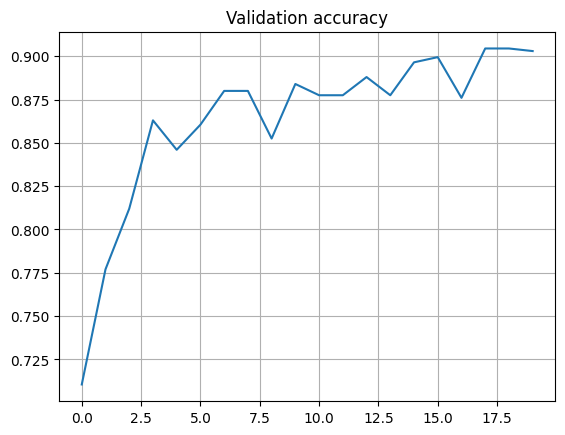

In [36]:
import matplotlib.pyplot as plt

plt.plot(val_accs)
plt.title("Validation accuracy")
plt.grid()
plt.show()

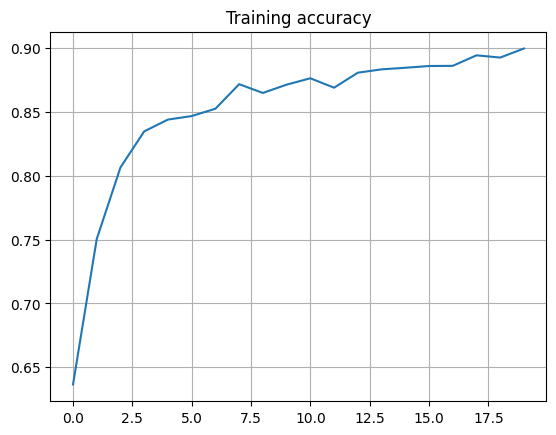

In [37]:
import matplotlib.pyplot as plt

plt.plot(train_accs)
plt.title("Training accuracy")
plt.grid()
plt.show()

**Q4** Interprete the following scatterplot:

Text(0, 0.5, '$\\hat{y}$')

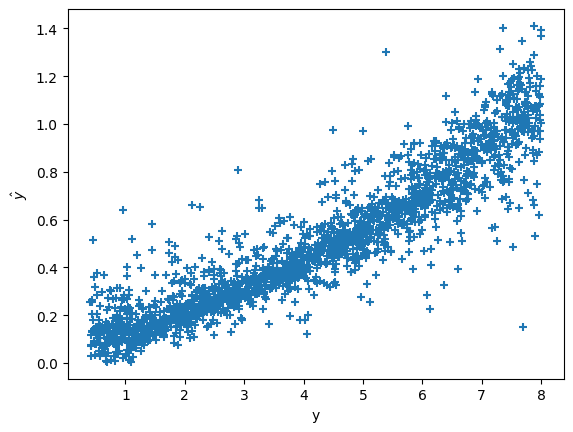

In [38]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


L'estimation de l'intensité de l'image according to the réseau augmente avec l'intensité de l'image (la vraie image y)

**Q5** Calculate the Spearman and Kendall rank correlations. Which of the two is related to the accuracy measure?

Spearman rank correlations : basé sur une donnée qu'on n'a pas toujours, on calcule le rang sorti par le réseau et on compare avec le rang des images (oracle) et on espère trouver la même chose (dans ce cas là, prohce de 1).
Kendall rank correlations : basé sur des pairs comparés, on va calculer le ratio de paris correctement comparés sur le nb de pairs qu'il fallait comparer

Rq : Pearson correlations : var / cov*cov

In [39]:
from scipy.stats import spearmanr, kendalltau

spearman, ps = spearmanr(ys, yhats)
kendall, pk = kendalltau(ys, yhats)

print(spearman)
print(kendall)

0.9374773518693381
0.7955917958979489


**Q6** We extend the training to 50 epochs. Load the following checkpoint, revisit questions 4 and 5 with this model, and provide comments.

In [40]:
os.chdir('/content')
! wget https://www.grosfichiers.com/WUuEwrxaf65_vySRhNAbepk
PATH_checkpoint = './WUuEwrxaf65_vySRhNAbepk'

--2023-12-22 09:59:47--  https://www.grosfichiers.com/WUuEwrxaf65_vySRhNAbepk
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134182874 (128M) [application/octet-stream]
Saving to: ‘WUuEwrxaf65_vySRhNAbepk.2’

WUuEwrxaf65_vySRhNA 100%[===================>] 127.97M  23.6MB/s    in 6.3s    

2023-12-22 09:59:54 (20.3 MB/s) - ‘WUuEwrxaf65_vySRhNAbepk.2’ saved [134182874/134182874]



In [45]:
model = resnet18(num_classes=1)
model.conv1 = nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias = False)
device = torch.device("cuda:0")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(PATH_checkpoint)
print(checkpoint.keys())

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
val_accs_control = checkpoint['val_accs']


num_epochs = 50

dict_keys(['val_accs', 'model', 'optimizer'])


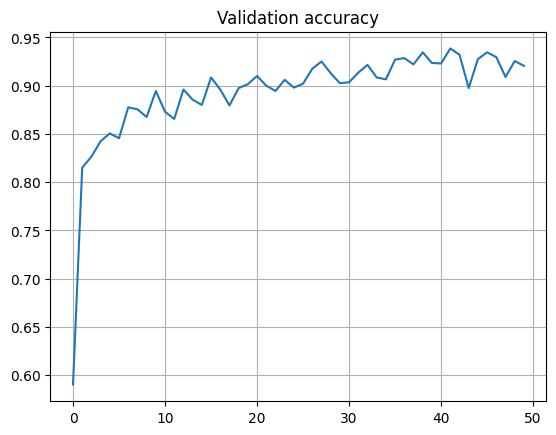

In [46]:
import matplotlib.pyplot as plt

plt.plot(val_accs_control)
plt.title("Validation accuracy")
plt.grid()
plt.show()

Text(0, 0.5, '$\\hat{y}$')

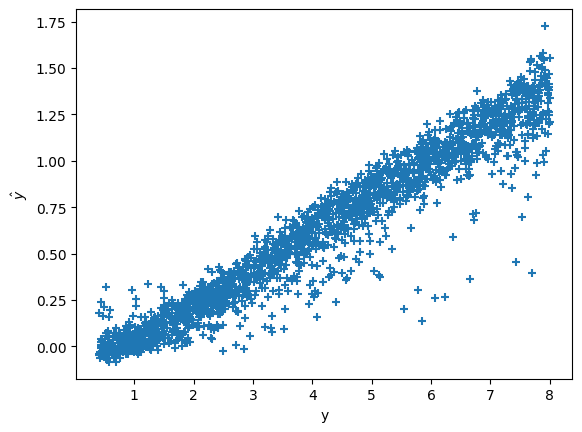

In [47]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


In [44]:
##### RECOPIAGE avec 50 epochs

num_epochs = 50
channels = 1

# With a ResNet18
model = resnet18(num_classes=1)
model.conv1 =  nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Init the new conv layer
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu") # on change la couche initiale en utiliasnt une initialisatoin de kaiming he.


device = torch.device("cuda:0")
model = model.to(device)

criterion = HingeLoss(0.1)
optimizer = optim.Adam(model.parameters(), lr = 0.002 )

# Loss function and optimizer
criterion = HingeLoss(margin=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:



            # TODO
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).detach()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model(img1)
              output2 = model(img2)
              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1) # on regarde si noter modèle apprend bien
              # max sur dim 1, on veut la colonne

              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1)) # unsqueeze permet d'avoir les labels en vecteur colonne

              if phase=='train':
                loss.backward()
                optimizer.step()


            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs.append(epoch_acc)


Epoch 1/50
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
plt.plot(val_accs)
plt.title("Validation accuracy")
plt.grid()
plt.show()

In [ ]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


On remarque que le nuage de points est + resserré que le nuage de points avec 20 epochs

**Q7** How would you improve performance?

I would improve performance using a bigger number for epochs

Curriculum Learning:
- Seek more "challenging" pairs towards the end of training.

Optimization:
- Consider adding a learning rate scheduler.

Other Loss Functions:
- Explore RankNet loss.
- Explore Listnet Loss.

**Exercice #3** Curriculum Learning

One idea is to make the problem harder after an initial training phase. The following code allows you to retrieve a ResNet18 trained for 50 epochs, the optimizer, and the associated learning curve:

**Q1** Take the ResNet18 trained on 50 epochs. Continue training for an additional 20 epochs without changing the dataloader. Remember to store accuracies related to the validation set and outputs related to the test set.

In [48]:
num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:



            # TODO
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).detach()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model(img1)
              output2 = model(img2)
              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1) # on regarde si noter modèle apprend bien
              # max sur dim 1, on veut la colonne

              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1)) # unsqueeze permet d'avoir les labels en vecteur colonne

              if phase=='train':
                loss.backward()
                optimizer.step()


            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs_control.append(epoch_acc)


Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0207 Acc: 0.9199


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0173 Acc: 0.9380
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0207 Acc: 0.9189


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0181 Acc: 0.9220
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0195 Acc: 0.9275


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0203 Acc: 0.9225
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0191 Acc: 0.9260


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0177 Acc: 0.9345
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0196 Acc: 0.9245


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0188 Acc: 0.9280
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0190 Acc: 0.9313


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0176 Acc: 0.9350
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0183 Acc: 0.9294


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0156 Acc: 0.9420
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0190 Acc: 0.9284


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0166 Acc: 0.9375
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0186 Acc: 0.9263


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0155 Acc: 0.9465
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0167 Acc: 0.9377


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0150 Acc: 0.9420
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0190 Acc: 0.9275


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0155 Acc: 0.9425
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0173 Acc: 0.9340


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0170 Acc: 0.9405
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0178 Acc: 0.9336


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0171 Acc: 0.9400
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0186 Acc: 0.9305


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0160 Acc: 0.9410
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0167 Acc: 0.9369


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0147 Acc: 0.9385
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0173 Acc: 0.9327


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0147 Acc: 0.9420
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0175 Acc: 0.9333


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0167 Acc: 0.9385
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0168 Acc: 0.9360


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0153 Acc: 0.9450
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0179 Acc: 0.9317


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0167 Acc: 0.9365
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0173 Acc: 0.9346


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0158 Acc: 0.9375


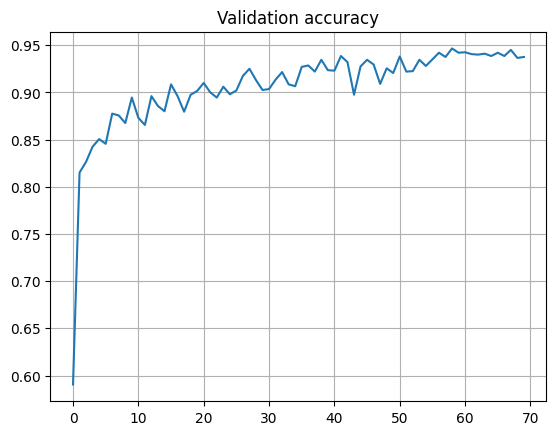

In [49]:
plt.plot(val_accs_control)
plt.title("Validation accuracy")
plt.grid()
plt.show()

Text(0, 0.5, '$\\hat{y}$')

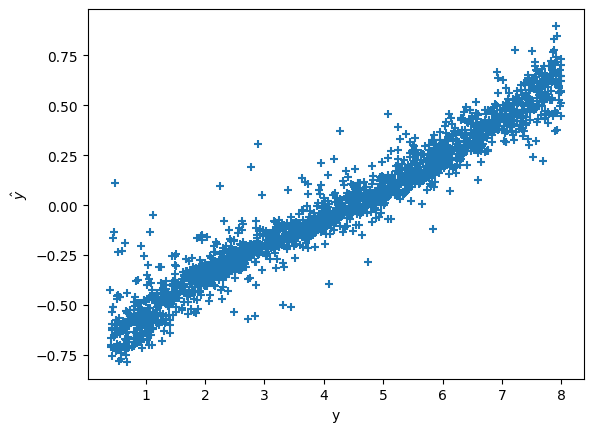

In [51]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


**Q2** We will now continue training on pairs that are harder to order. For this purpose, we have the 'Dataset_finer_pairs' dataset below. Train for 20 epochs using this dataset (use epoch_ray = 1.).

In [52]:
def make_dic_ray(imgs, dic, ray):

  ys = np.array([dic[img]['y'] for img in imgs])
  imgs = np.array(imgs)
  dic_ray = {}
  for i,img in enumerate(imgs):
    y = ys[i]
    # on limite la paire à des disques proches en intensité
    dic_ray[img] = list(imgs[np.abs(ys - y) < ray])

  return dic_ray

class Dataset_finer_pairs(torch.utils.data.Dataset):
    def __init__(self, images_dir,  dic, transfo = None, ray=0.5):
        self.images_dir = images_dir
        self.transfo = transfo
        self.imgs = sorted(ls(images_dir))
        self.dic = dic
        self.dic_ray = make_dic_ray(self.imgs, dic, ray)

    def __getitem__(self,idx):

        name0 = self.imgs[idx]
        name1 = choice(self.dic_ray[name0])
        label = oracle(name0, name1, self.dic)


        #get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 =  torch.load(path0)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1)


        if self.transfo is not None:
            img0 = self.transfo(img0)
            img1 = self.transfo(img1)

        return img0, img1,  torch.from_numpy(np.array(label)).long(), name0, name1

    def __len__(self):
        return len(self.imgs)

In [53]:
# Dataset instantiation:
epoch_ray = 1.
dataset_train = Dataset_finer_pairs(dir_images_trainval, label_dict_trainval, transforms['train'], ray=epoch_ray)

dataloaders['train'] = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False, sampler = samplers['train'],num_workers=2)


In [54]:
from torchvision.models import resnet18

model = resnet18(num_classes=1)
model.conv1 = nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias = False)
device = torch.device("cuda:0")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(PATH_checkpoint)
print(checkpoint.keys())

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
val_accs_curriculum = checkpoint['val_accs']

dict_keys(['val_accs', 'model', 'optimizer'])


In [55]:
num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:



            # TODO
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).detach()

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model(img1)
              output2 = model(img2)
              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1) # on regarde si noter modèle apprend bien
              # max sur dim 1, on veut la colonne

              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1)) # unsqueeze permet d'avoir les labels en vecteur colonne

              if phase=='train':
                loss.backward()
                optimizer.step()


            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs_curriculum.append(epoch_acc)


Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0671 Acc: 0.7342


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0193 Acc: 0.9280
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0666 Acc: 0.7375


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0182 Acc: 0.9345
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0647 Acc: 0.7470


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0190 Acc: 0.9340
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0608 Acc: 0.7620


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0183 Acc: 0.9295
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0612 Acc: 0.7632


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0158 Acc: 0.9400
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0613 Acc: 0.7636


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0182 Acc: 0.9340
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0581 Acc: 0.7854


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0141 Acc: 0.9470
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0579 Acc: 0.7741


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0172 Acc: 0.9435
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0569 Acc: 0.7810


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0143 Acc: 0.9450
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0554 Acc: 0.7890


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0132 Acc: 0.9470
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0534 Acc: 0.7966


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0149 Acc: 0.9500
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0542 Acc: 0.7970


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0159 Acc: 0.9420
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0525 Acc: 0.7993


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0141 Acc: 0.9515
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0531 Acc: 0.7995


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0154 Acc: 0.9480
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0513 Acc: 0.8051


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0128 Acc: 0.9565
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0506 Acc: 0.8117


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0148 Acc: 0.9525
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0500 Acc: 0.8085


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0133 Acc: 0.9545
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0514 Acc: 0.8083


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0127 Acc: 0.9560
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0479 Acc: 0.8193


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0118 Acc: 0.9545
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0486 Acc: 0.8153


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0132 Acc: 0.9475


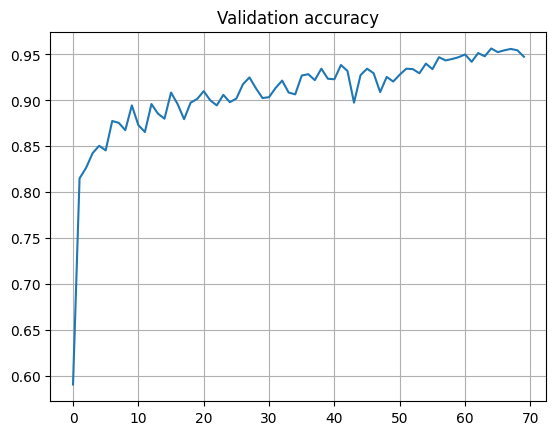

In [56]:
plt.plot(val_accs_curriculum)
plt.title("Validation accuracy")
plt.grid()
plt.show()

**Q3** Why is the training accuracy lower than before? Compare the learning curves (validation accuracies) and the results on the test set. Discuss.

C'est mieux d'apprendre d'abord sur simple puis de rendre l'exercice plus difficile.

**Exercise #4** RankNet Loss (and ListNet Loss)

A milder version of the Hinge Loss has been widely used, particularly in search engine learning, known as the RankNet Loss.

This cost function is derived from a parametric probabilistic model, the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model).

In a general version, it is assumed that the outcome of a comparison (or match) between two objects "0" and "1" (or two teams) is random and depends on real values associated with the objects (the "team levels") as follows:
\begin{align}
P_0 = \dfrac{f(y_0)}{f(y_0) + f(y_1)}
\tag{1}
\end{align}
Where $P_0$ is the probability of choosing object "0" (or the first team winning), and $f$ is a strictly increasing function with positive values.

**Q1** In the case where $f(y) = e^{\sigma y}$, what do the choice probabilities depend on? Write the log-likelihood of the event "object $x$ is chosen."

**Q2** Derive an appropriate cost function for our ranking problem based on the given log-likelihood.

**Q3** Implement and compare over twenty epochs.